# Часть 1

### Загрузка данных

In [25]:
import pandas as pd
import librosa
import numpy as np
import librosa.display
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook as tqdm
import os


import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import plotly.graph_objs as go
import plotly.offline as py
from scipy import signal
from scipy.io import wavfile

import IPython
import pickle

In [1]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [26]:
path = 'esc50.csv' # путь к фрейму
path_audio = 'audio/audio/' # путь к аудио

In [27]:
df = pd.read_csv(path) # read CSV

In [4]:
classes = df['category'].unique()
print("Classes are: ",classes) # class information

Classes are:  ['dog' 'chirping_birds' 'vacuum_cleaner' 'thunderstorm' 'door_wood_knock'
 'can_opening' 'crow' 'clapping' 'fireworks' 'chainsaw' 'airplane'
 'mouse_click' 'pouring_water' 'train' 'sheep' 'water_drops'
 'church_bells' 'clock_alarm' 'keyboard_typing' 'wind' 'footsteps' 'frog'
 'cow' 'brushing_teeth' 'car_horn' 'crackling_fire' 'helicopter'
 'drinking_sipping' 'rain' 'insects' 'laughing' 'hen' 'engine' 'breathing'
 'crying_baby' 'hand_saw' 'coughing' 'glass_breaking' 'snoring'
 'toilet_flush' 'pig' 'washing_machine' 'clock_tick' 'sneezing' 'rooster'
 'sea_waves' 'siren' 'cat' 'door_wood_creaks' 'crickets']


In [5]:
class_dict = {i:x for x,i in enumerate(classes)}
df = df.drop_duplicates(subset=['filename'])

In [6]:
df['target'] = df['category'].map(class_dict) # соотношение категорий к таргету

### Ознакомление с аудиоклипами

**Рис 1.**


![image](https://i.ibb.co/m4fxvkN/2022-12-06-11-51-38.png)

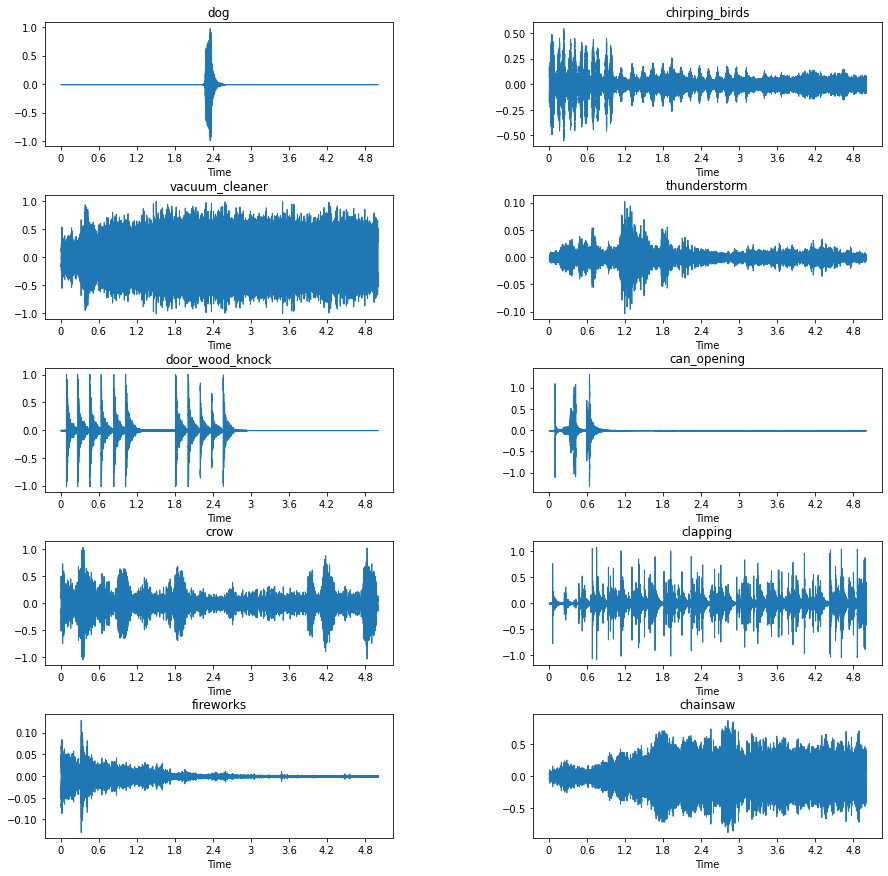

In [8]:
# Отоброжение аудиодорожек по классам
files = dict()
for i in range(len(classes)):
    tmp = df[df['category'] == classes[i]][:1].reset_index()
    path = 'audio/audio/{}'.format(tmp['filename'][0])
    files[classes[i]] = path
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i, label in enumerate(classes[:10]):
    fn = files[label]
    fig.add_subplot(5, 2, i+1)
    plt.title(label)
    data, sample_rate = librosa.load(fn)
    display.waveshow(data, sr= sample_rate)

# Часть 2

**Рис STFT**

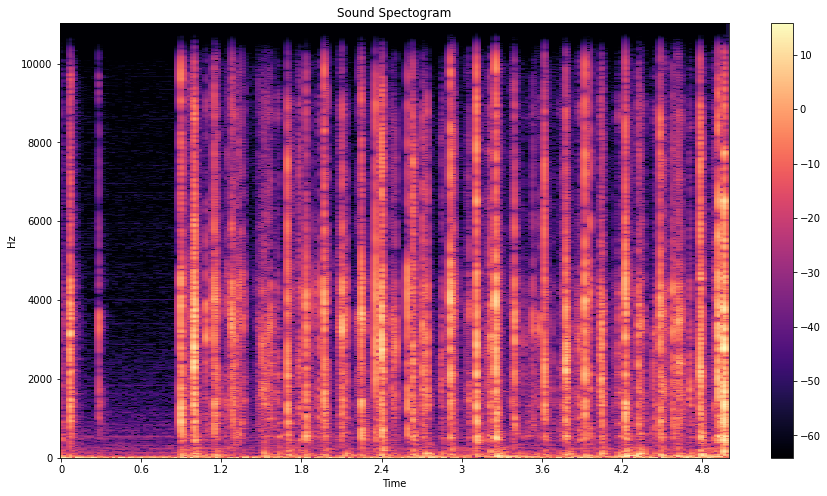

In [18]:
x,sr = librosa.load('audio/audio/1-137-A-32.wav')
X=librosa.stft(x) #STFT -> Short-time Fourier transform 
X_db=librosa.amplitude_to_db(abs(X)) # Translation from amplitude to desibel(db) value
plt.figure(figsize=(15,8))
librosa.display.specshow(X_db, sr=sr,x_axis="time",y_axis="hz")
plt.title("Sound Spectogram")
plt.colorbar();

**Зависимость Mel** 

![image](https://i.ibb.co/kg0FFJb/2022-12-06-14-15-11.png)

In [11]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)
def plot_raw_wave(samples):
    plt.figure(figsize=(10, 3))
    plt.title('Audio wave')
    plt.ylabel('Amplitude')
    # ax1.plot(np.linspace(0, sample_rate/len(samples1), sample_rate), samples1)
    plt.plot(samples)
    plt.show()

In [13]:
sample_rate, sample = wavfile.read('audio/audio/1-137-A-32.wav')

In [23]:
S = librosa.feature.melspectrogram(sample.astype(float), sr=sample_rate, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

/tmp/ipykernel_3682/2927186072.py:1: FutureWarning:

Pass y=[292. 293. 290. ... 112. 126. 126.] as keyword args. From version 0.10 passing these as positional arguments will result in an error



In [24]:
freqs, times, spectrogram = log_specgram(sample, sample_rate)
data = [go.Surface(z=spectrogram.T)]
layout = go.Layout(
    title='Specgtogram 3d',
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

In [31]:
# Функция для отображения melspectrogram and MFCC преобразования
def melspectro_and_mfcc(audio_file):
    librosa_audio, librosa_sample_rate = librosa.load(audio_file) # На вход поступает файл
    S = librosa.feature.melspectrogram(y=librosa_audio, sr=librosa_sample_rate, n_mels=128,
                                   fmax=17000) # Подбор параметров
    mfccs = librosa.feature.mfcc(y=librosa_audio, sr=librosa_sample_rate, n_mfcc=32) # Same
    fig, ax = plt.subplots(figsize=(15,15), nrows=2, sharex=True)
    img = librosa.display.specshow(librosa.power_to_db(S, ref=np.max),
                               x_axis='time', y_axis='mel', fmax=16000,
                               ax=ax[0])
    
    fig.colorbar(img, ax=[ax[0]])
    ax[0].set(title='Mel spectrogram')
    ax[0].label_outer()
    img = librosa.display.specshow(mfccs, x_axis='time', ax=ax[1])
    fig.colorbar(img, ax=[ax[1]])
    ax[1].set(title='MFCC');

**dog**

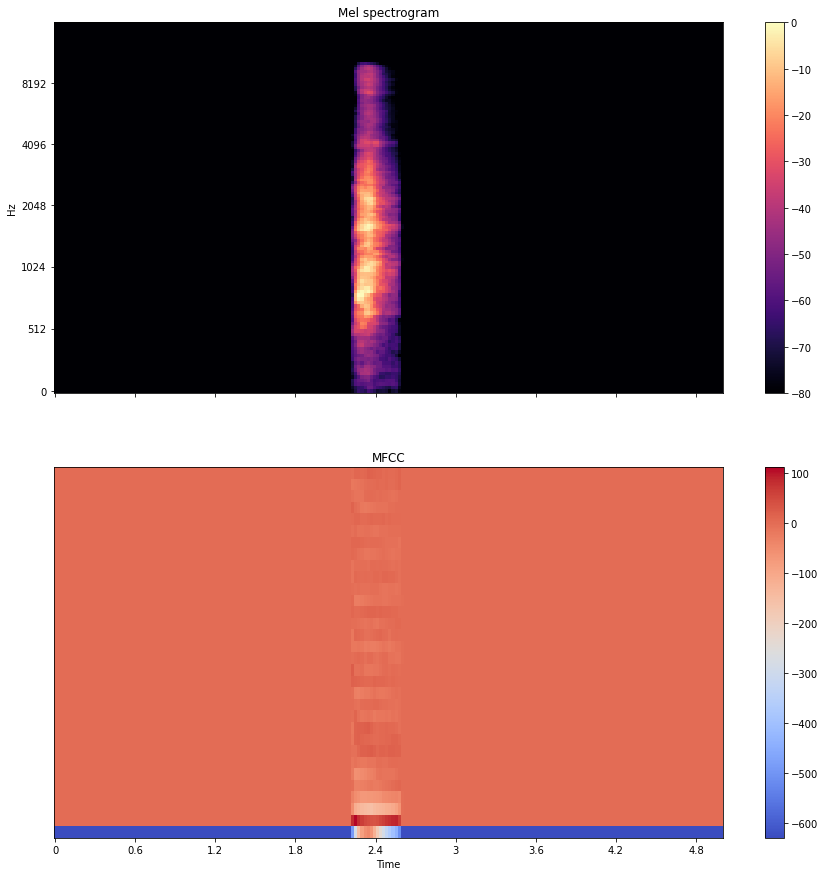

In [32]:
melspectro_and_mfcc('audio/audio/1-100032-A-0.wav')

**chirping_birds**

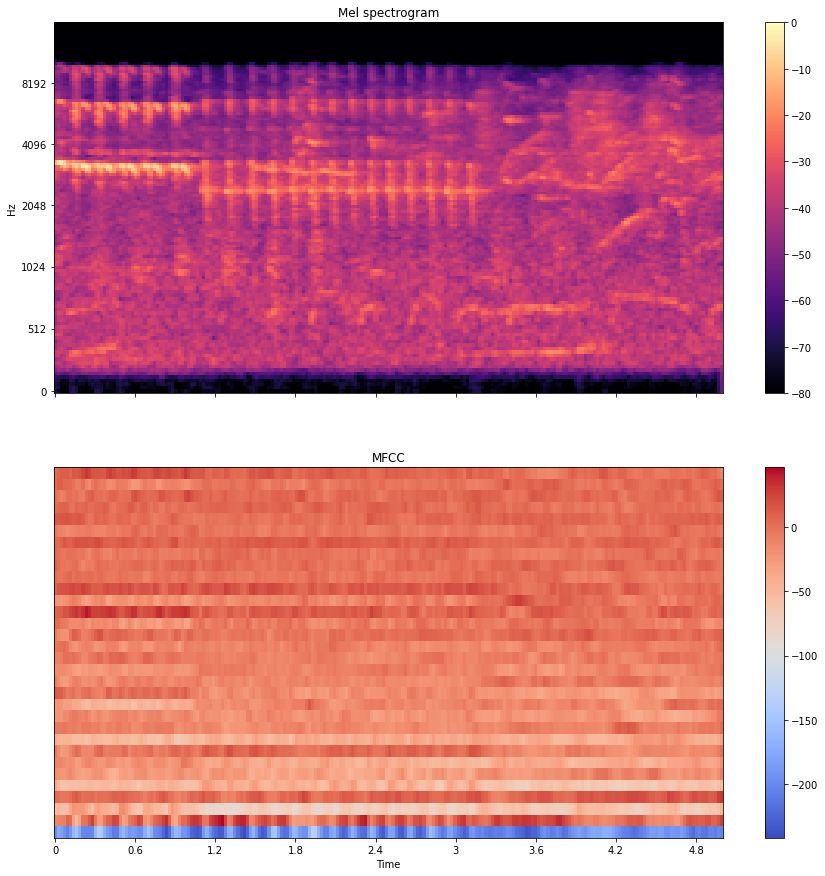

In [33]:
melspectro_and_mfcc('audio/audio/1-100038-A-14.wav')

**vacuum_cleaner**

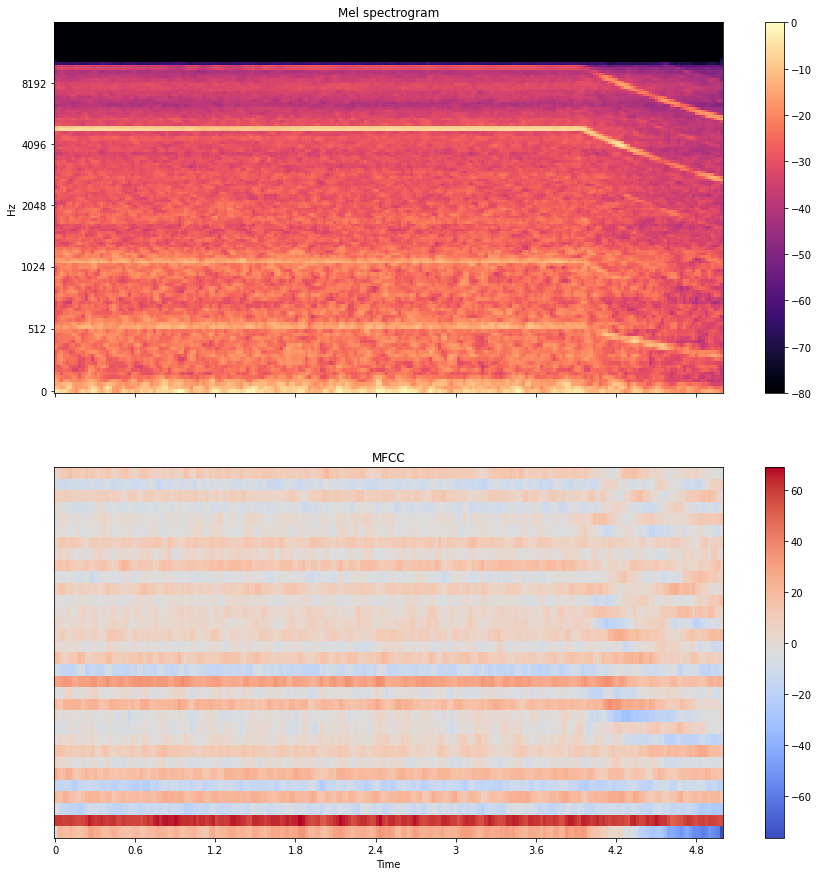

In [34]:
melspectro_and_mfcc('audio/audio/1-100210-B-36.wav')

**thunderstorm**

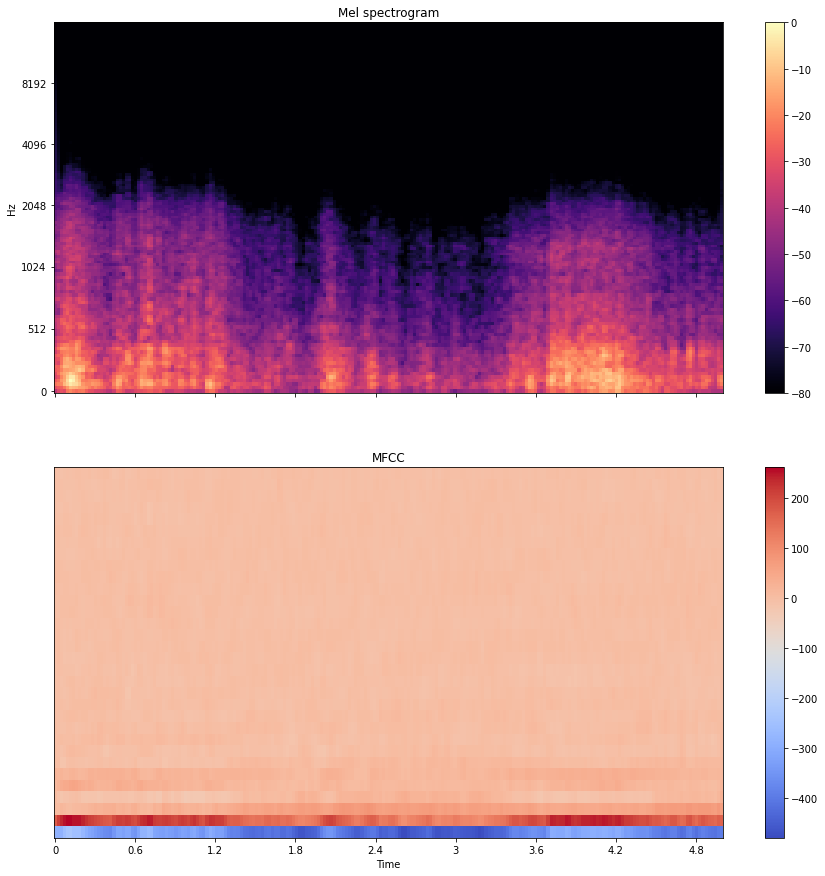

In [35]:
melspectro_and_mfcc('audio/audio/1-115521-A-19.wav')

**hen**

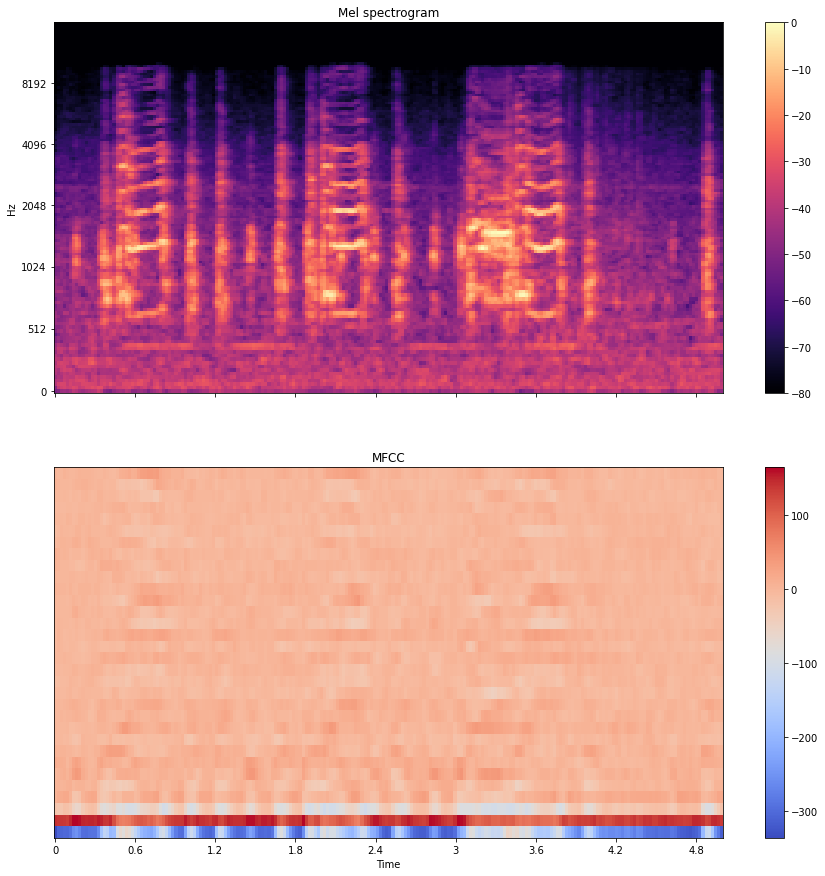

In [36]:
melspectro_and_mfcc('audio/audio/5-263831-B-6.wav')

**footsteps**

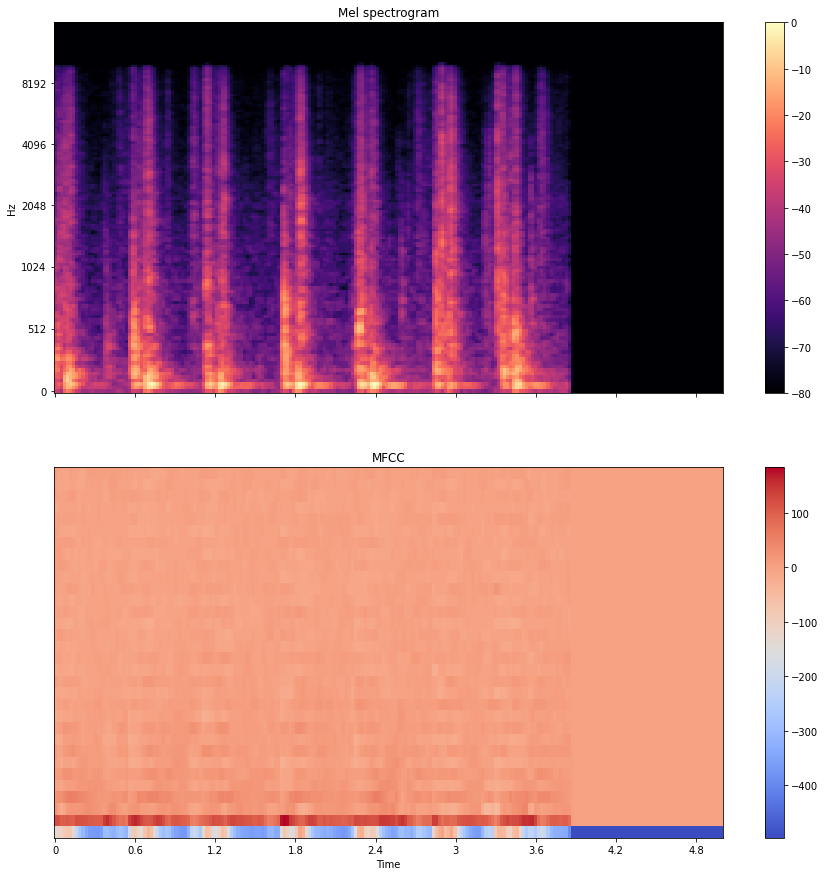

In [37]:
melspectro_and_mfcc('audio/audio/5-51149-A-25.wav')

**sheep**

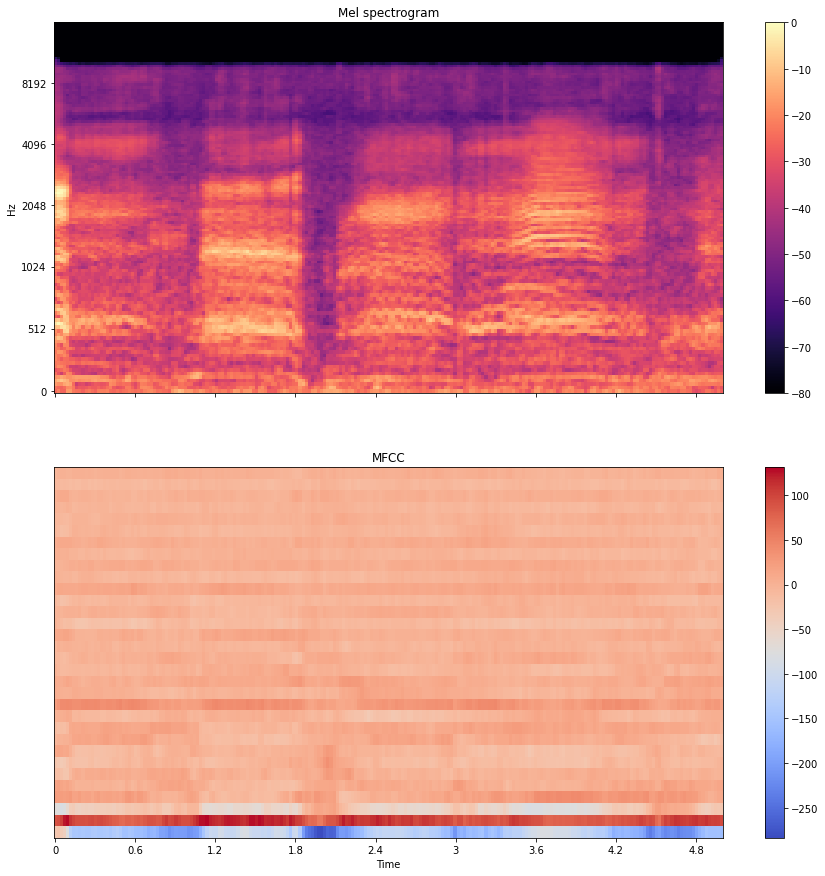

In [38]:
melspectro_and_mfcc('audio/audio/5-61635-A-8.wav')

**clapping**

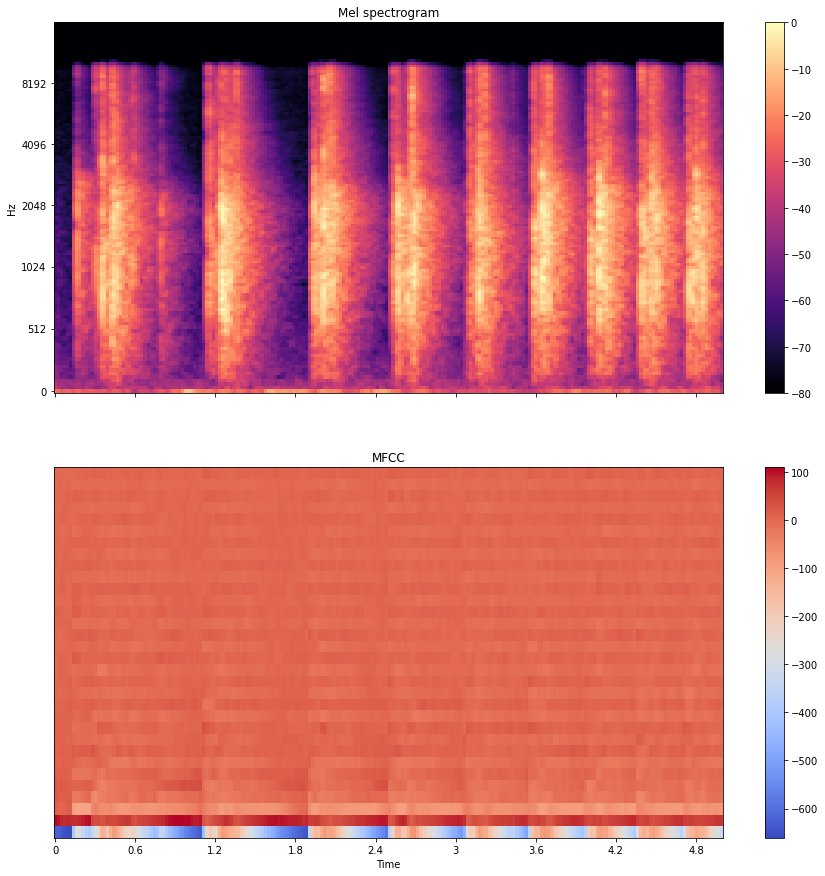

In [39]:
melspectro_and_mfcc('audio/audio/1-115920-A-22.wav')

# Часть 3

In [28]:
train = df[df['fold']!=5]
valid = df[df['fold']==5]

In [29]:
wav, sr = librosa.load('audio/audio/1-100032-A-0.wav', sr=None)
print(f'Sampling rate of the audio is {sr} and length of the audio is {len(wav)/sr} seconds')

Sampling rate of the audio is 44100 and length of the audio is 5.0 seconds


In [39]:
# Функция для image
def spec_to_image(spec, eps=1e-6):
  mean = spec.mean()
  std = spec.std()
  spec_norm = (spec - mean) / (std + eps)
  spec_min, spec_max = spec_norm.min(), spec_norm.max()
  spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
  spec_scaled = spec_scaled.astype(np.uint8)
  return spec_scaled

In [40]:
# Мелспектрограмма с подобранными параметрами
def get_melspectrogram(file_path, sr=44100, n_fft=16384, hop_length=308, n_mels=256, fmin=20, fmax=17000, top_db=80, win_length=3969):
  wav,sr = librosa.load(file_path,sr=sr)
  if wav.shape[0]<5*sr:
    wav=np.pad(wav,int(np.ceil((5*sr-wav.shape[0])/2)),mode='reflect')
  else:
    wav=wav[:5*sr]
  spec=librosa.feature.melspectrogram(wav, sr=sr, n_fft=n_fft,
              hop_length=hop_length,n_mels=n_mels,fmin=fmin,fmax=fmax, win_length=win_length)
  spec_db=librosa.power_to_db(spec,top_db=top_db)
  return spec_db

In [42]:
# Класс для преобразования аудиоклипов в img
class Network(Dataset):
  def __init__(self, base, df, in_col, out_col):
    self.df = df
    self.data = []
    self.labels = []
    self.c2i={}
    self.i2c={}
    self.categories = sorted(df[out_col].unique())
    for i, category in enumerate(self.categories):
      self.c2i[category]=i
      self.i2c[i]=category
    for ind in tqdm(range(len(df))):
      row = df.iloc[ind]
      file_path = os.path.join(base,row[in_col])
      self.data.append(spec_to_image(get_melspectrogram(file_path))[np.newaxis,...])
      self.labels.append(self.c2i[row['category']])
  def __len__(self):
    return len(self.data)
  def __getitem__(self, idx):
    return self.data[idx], self.labels[idx]

In [37]:
filename = valid[valid['category']=='clock_tick'].iloc[0]['filename']
wav, sr = librosa.load('audio/audio/'+filename, sr=None)
# librosa.display.waveplot(wav, sr);

/tmp/ipykernel_3682/2399079495.py:8: FutureWarning:

Pass y=[-0.00018311 -0.00027466 -0.00015259 ... -0.0010376  -0.00115967
 -0.00076294] as keyword args. From version 0.10 passing these as positional arguments will result in an error



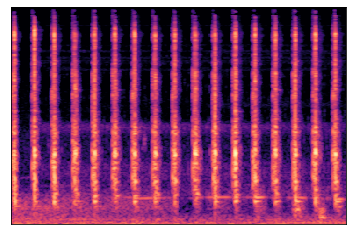

In [41]:
librosa.display.specshow(spec_to_image(get_melspectrogram('audio/audio/'+filename, sr)));

# Часть 4

In [44]:
train_data = Network('audio/audio/', train, 'filename', 'category')

/tmp/ipykernel_3682/30351978.py:13: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/tmp/ipykernel_3682/2399079495.py:8: FutureWarning:

Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error

/tmp/ipykernel_3682/2399079495.py:8: FutureWarning:

Pass y=[-0.01184082 -0.10336304 -0.14141846 ...  0.06985474  0.04049683
  0.00274658] as keyword args. From version 0.10 passing these as positional arguments will result in an error

/tmp/ipykernel_3682/2399079495.py:8: FutureWarning:

Pass y=[-0.00695801 -0.01251221 -0.01126099 ...  0.215271   -0.00875854
 -0.28903198] as keyword args. From version 0.10 passing these as positional arguments will result in an error

/tmp/ipykernel_3682/2399079495.py:8: FutureWarning:

Pass y=[0.53897095 0.39627075 0.26739502 ... 0.09729004 0.11227417 0.07983398] as keyword args. From version 0.10 passing these as positional arguments will result in an error

/tmp/ipykernel_3682/2399079495.py:8: FutureWarning:

Pass y=[-0.00036621 -0.0007019  -0.00079346 ...  0.00317383  

In [45]:
valid_data = Network('audio/audio/', valid, 'filename', 'category')

/tmp/ipykernel_3682/30351978.py:13: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/tmp/ipykernel_3682/2399079495.py:8: FutureWarning:

Pass y=[0.16473389 0.17315674 0.17971802 ... 0.26345825 0.1300354  0.03866577] as keyword args. From version 0.10 passing these as positional arguments will result in an error

/tmp/ipykernel_3682/2399079495.py:8: FutureWarning:

Pass y=[-0.18862915 -0.1513977  -0.1326294  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error

/tmp/ipykernel_3682/2399079495.py:8: FutureWarning:

Pass y=[0.0826416  0.06454468 0.05496216 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error

/tmp/ipykernel_3682/2399079495.py:8: FutureWarning:

Pass y=[-0.18951416  0.01144409  0.16595459 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error

/tmp/ipykernel_3682/2399079495.py:8: FutureWarning:

Pass y=[-0.0007019  -0.009521

In [48]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=64, shuffle=True)

In [49]:
if torch.cuda.is_available():
  device=torch.device('cuda:0')
else:
  device=torch.device('cpu')

In [50]:
from torchvision.models import resnet18
cnn = resnet18(pretrained=True)
cnn.fc = nn.Linear(512,50)
cnn.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
cnn = cnn.to(device)

In [51]:
from torch import nn
from torchsummary import summary

In [52]:
summary(cnn, (1, 64, 44))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 22]           3,136
       BatchNorm2d-2           [-1, 64, 32, 22]             128
              ReLU-3           [-1, 64, 32, 22]               0
         MaxPool2d-4           [-1, 64, 16, 11]               0
            Conv2d-5           [-1, 64, 16, 11]          36,864
       BatchNorm2d-6           [-1, 64, 16, 11]             128
              ReLU-7           [-1, 64, 16, 11]               0
            Conv2d-8           [-1, 64, 16, 11]          36,864
       BatchNorm2d-9           [-1, 64, 16, 11]             128
             ReLU-10           [-1, 64, 16, 11]               0
       BasicBlock-11           [-1, 64, 16, 11]               0
           Conv2d-12           [-1, 64, 16, 11]          36,864
      BatchNorm2d-13           [-1, 64, 16, 11]             128
             ReLU-14           [-1, 64,

In [53]:
def setlr(optimizer, lr):
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr
  return optimizer

In [54]:
def train(cnn, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, change_lr=None):
  for epoch in tqdm(range(1,epochs+1)):
    cnn.train()
    batch_losses=[]
    if change_lr:
      optimizer = change_lr(optimizer, epoch)
    for i, data in enumerate(train_loader):
      x, y = data
      optimizer.zero_grad()
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = cnn(x)
      loss = loss_fn(y_hat, y)
      loss.backward()
      batch_losses.append(loss.item())
      optimizer.step()
    train_losses.append(batch_losses)
    print(f'Epoch - {epoch} Train-Loss : {np.mean(train_losses[-1])}')
    cnn.eval()
    batch_losses=[]
    trace_y = []
    trace_yhat = []
    for i, data in enumerate(valid_loader):
      x, y = data
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = cnn(x)
      loss = loss_fn(y_hat, y)
      trace_y.append(y.cpu().detach().numpy())
      trace_yhat.append(y_hat.cpu().detach().numpy())      
      batch_losses.append(loss.item())
    valid_losses.append(batch_losses)
    trace_y = np.concatenate(trace_y)
    trace_yhat = np.concatenate(trace_yhat)
    accuracy = np.mean(trace_yhat.argmax(axis=1)==trace_y)
    print(f'Epoch - {epoch} Valid-Loss : {np.mean(valid_losses[-1])} Valid-Accuracy : {accuracy}')

In [1]:
learning_rate = 2e-4
optimizer = optim.Adam(cnn.parameters(), lr=learning_rate)
epochs = 80
loss_fn = nn.CrossEntropyLoss()
cnn_train_losses=[]
cnn_valid_losses=[]
def lr_decay(optimizer, epoch):
  if epoch%10==0:
    new_lr = learning_rate / (10**(epoch//10))
    optimizer = setlr(optimizer, new_lr)
    print(f'Changed learning rate to {new_lr}')
  return optimizer
train(cnn, loss_fn, train_loader, valid_loader, epochs, optimizer, cnn_train_losses, cnn_valid_losses, lr_decay)

# Результат ResNet18

In [ ]:
tl = np.asarray(cnn_train_losses).ravel()
vl = np.asarray(cnn_valid_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])

In [ ]:
# Best result - 0.8025

# Save model

In [ ]:
with open('esc50resnet18.pth','wb') as f:
  torch.save(cnn, f)

In [ ]:
with open('indtocat.pkl','wb') as f:
  pickle.dump(train_data.i2c, f)

# Try18

In [ ]:
with open('indtocat.pkl','rb') as f:
  indtocat = pickle.load(f)
filename='' # Your file
spec=spec_to_image(get_melspectrogram(filename))
spec_t=torch.tensor(spec).to(device, dtype=torch.float32)
pr=cnn.forward(spec_t.reshape(1,1,*spec_t.shape))
ind = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
print(indtocat[ind])
IPython.display.display(IPython.display.Audio(filename=filename))

# ResNet50

In [ ]:
from torchvision.models import resnet50
resnet_model = resnet50(pretrained=True)
resnet_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet_model.fc = nn.Linear(in_features=2048, out_features=50, bias=True)
resnet_model = resnet_model.to(device)

In [ ]:
def train(resnet_model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, change_lr=None):
  for epoch in tqdm(range(1,epochs+1)):
    resnet_model.train()
    batch_losses=[]
    if change_lr:
      optimizer = change_lr(optimizer, epoch)
    for i, data in enumerate(train_loader):
      x, y = data
      optimizer.zero_grad()
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = resnet_model(x)
      loss = loss_fn(y_hat, y)
      loss.backward()
      batch_losses.append(loss.item())
      optimizer.step()
    train_losses.append(batch_losses)
    print(f'Epoch - {epoch} Train-Loss : {np.mean(train_losses[-1])}')
    resnet_model.eval()
    batch_losses=[]
    trace_y = []
    trace_yhat = []
    for i, data in enumerate(valid_loader):
      x, y = data
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = resnet_model(x)
      loss = loss_fn(y_hat, y)
      trace_y.append(y.cpu().detach().numpy())
      trace_yhat.append(y_hat.cpu().detach().numpy())      
      batch_losses.append(loss.item())
    valid_losses.append(batch_losses)
    trace_y = np.concatenate(trace_y)
    trace_yhat = np.concatenate(trace_yhat)
    accuracy = np.mean(trace_yhat.argmax(axis=1)==trace_y)
    print(f'Epoch - {epoch} Valid-Loss : {np.mean(valid_losses[-1])} Valid-Accuracy : {accuracy}')

In [ ]:
learning_rate = 2e-4
optimizer = optim.Adam(resnet_model.parameters(), lr=learning_rate)
epochs = 80
loss_fn = nn.CrossEntropyLoss()
resnet_model_train_losses=[]
resnet_model_valid_losses=[]
def lr_decay(optimizer, epoch):
  if epoch%10==0:
    new_lr = learning_rate / (10**(epoch//10))
    optimizer = setlr(optimizer, new_lr)
    print(f'Changed learning rate to {new_lr}')
  return optimizer
train(resnet_model, loss_fn, train_loader, valid_loader, epochs, optimizer, resnet_model_train_losses, resnet_model_valid_losses, lr_decay)

# Результат ResNet50

In [ ]:
tl = np.asarray(resnet_model_train_losses).ravel()
vl = np.asarray(resnet_model_valid_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])

# Save model

In [ ]:
with open('esc50resnet50.pth','wb') as f:
  torch.save(resnet_model, f)

# Try50

In [ ]:
filename='' # Your file
spec=spec_to_image(get_melspectrogram(filename))
spec_t=torch.tensor(spec).to(device, dtype=torch.float32)
pr=resnet_model.forward(spec_t.reshape(1,1,*spec_t.shape))
ind = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
print(indtocat[ind])
IPython.display.display(IPython.display.Audio(filename=filename))